In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Avalanche Airbag Simulation

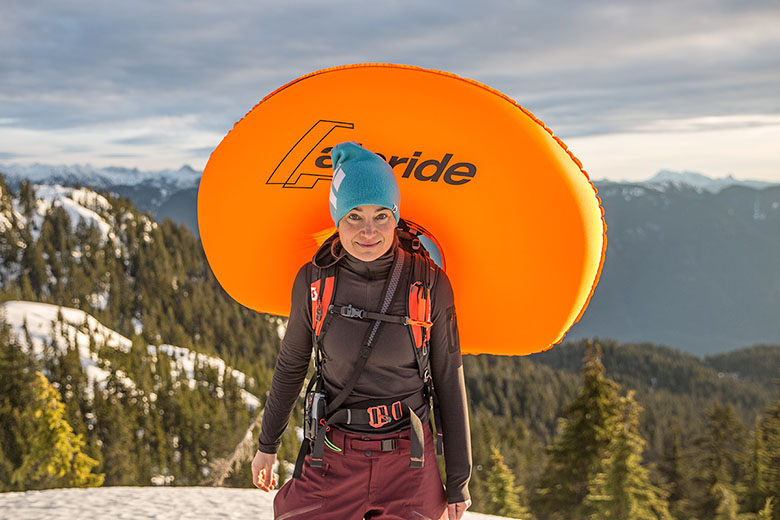

Avalanche airbags are a relatively new development in backcountry safety equipment. When triggered by a rip cord they inflate rapidly, maximizing the volume of an individual caught in an avalanche in an attempt to minimize their burial depth. My senior design group is attemptign to improve the current offerings on the market, and one of the ways we intend to do so is with something called dual-walled inflation. 

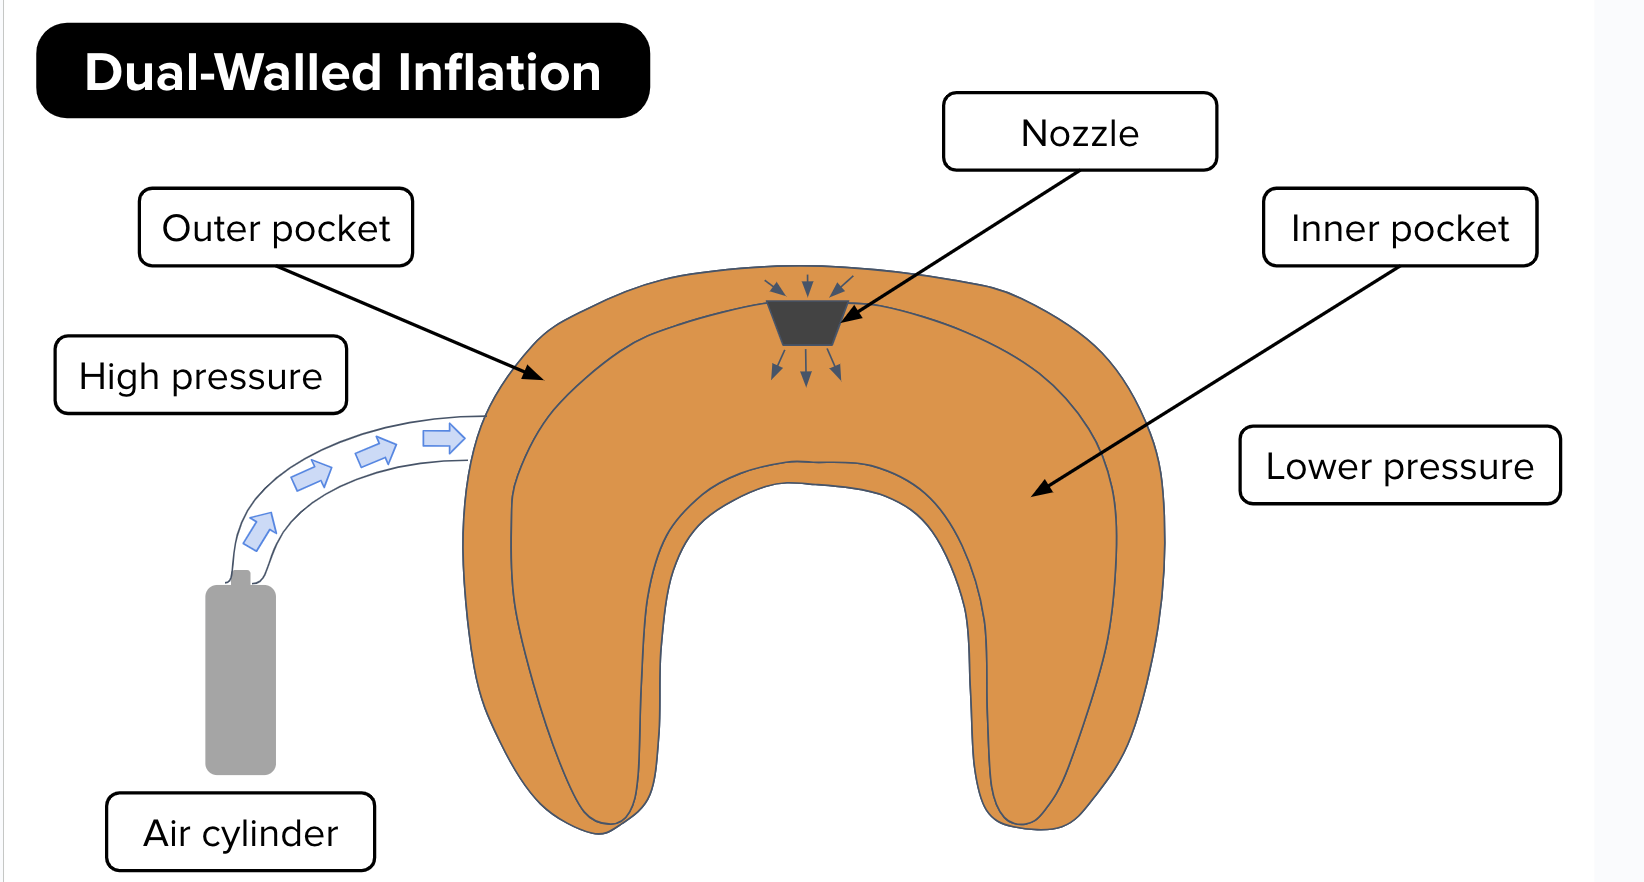

Dual-walled inflation seperates the airbag into two chambers: an outer and an inner. The compressed air cylinder delivers air directly to the outer chamber in an attempt to achieve it's maximum shape faster than a traditional airbag of the same volume. Between the outer and inner chamber there is a valve that allows flow between them, allowing for the chambers to equilibrize in pressure after the initial inflation. This results in a quicker initial inflation, with homogenous pressure being achieved passively shortly after inflation. 

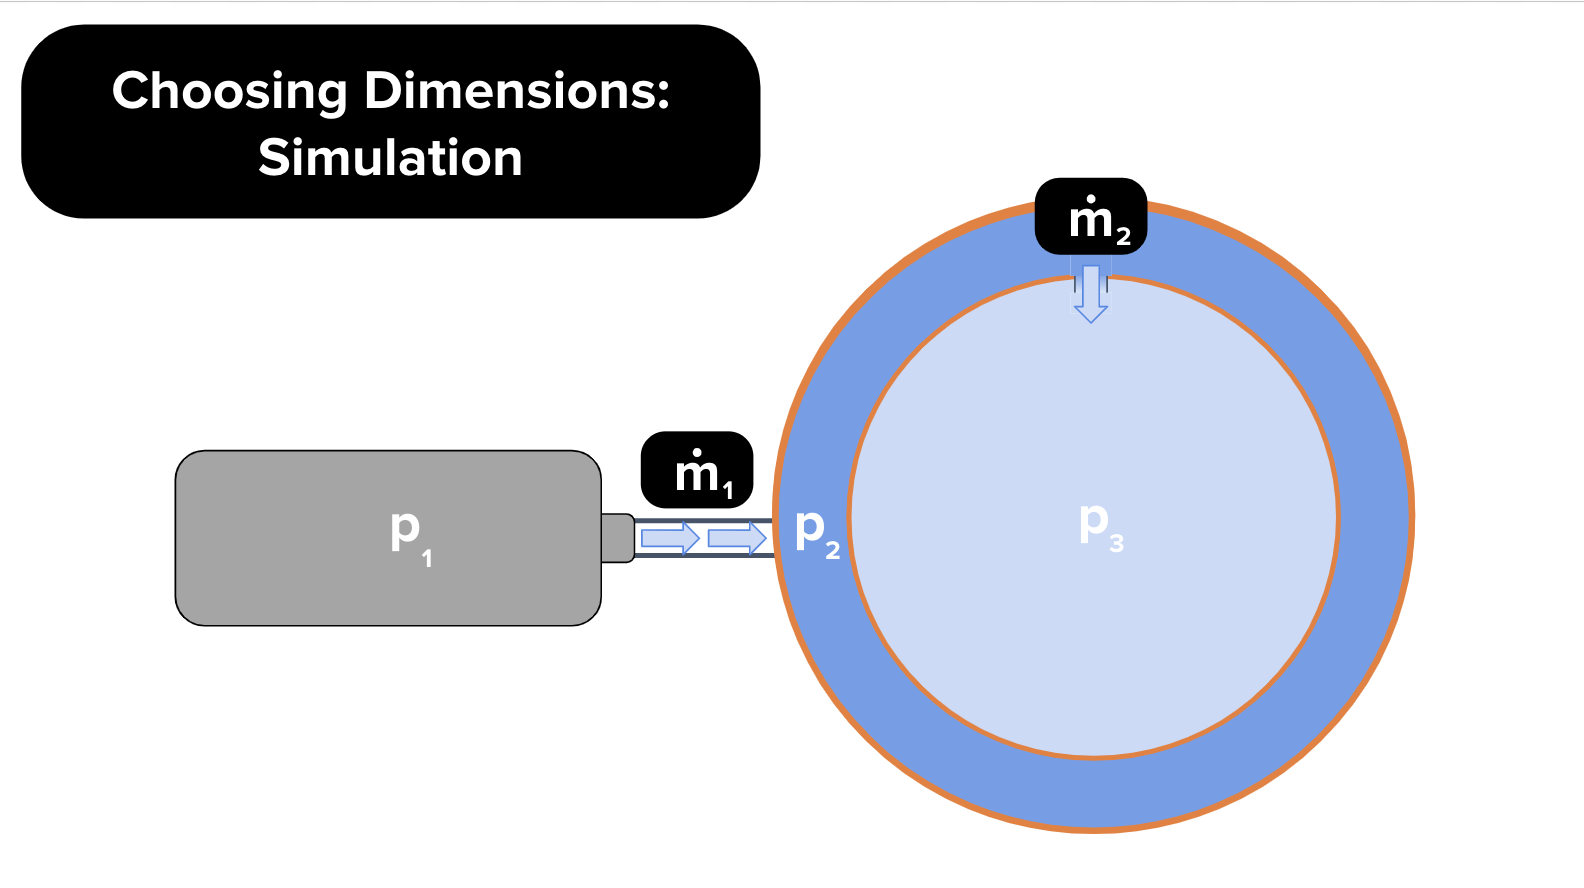

In order to create a prototype, the group needed some intuition as to the size of the hole between the outer and inner chamber. In order to do so, I created this code that modeled pressure of each chamber as a function of time given initial pressure and volume of a standard compressed air cylinder. 

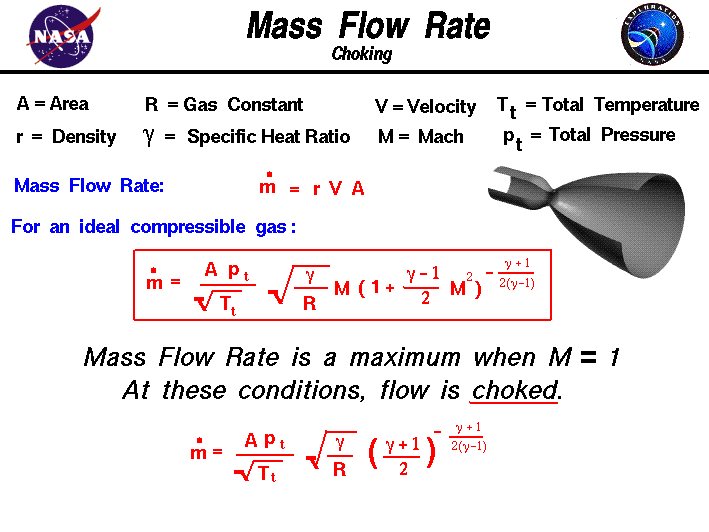

## Ideal Gas Law: $PV = nRT  \implies \frac{dP}{dt} = \frac{d}{dt} (\frac{nRT}{V}) $

## $\therefore \frac{dP}{dt} = (\frac{\dot{m}RT}{V}) $

 - P = Pressure
 - V = Volume
 - n = Number of mols of gas
 - R = Specific Ideal Gas Constant
 - T = Temperature

My calculations mostly depend on the ideal gas law and choked/unchoked flow equations shown above, thus they assume compressible ideal gas behavior. I then ran the code with various valve areas to get an estimations of the: time required for initial inflation, time required to reach equilibrium pressure, pressure differential between the two chambers, and maximum pressure experienced by each chamber. These values allow us to pick an estimated ideal valve area that doesn't reach the yield strength airbag material and has ideal inflation and pressure equilibrium times. 

### Constant/Assumed Values

In [ ]:
R = 287.05  #Specific gas constant (J/(kg·K))
Cd = 0.6  #Discharge coef (for hole in thin plate)
P_ambient = 1.01e5  #Ambient
T_inlet = 300  #Inlet temp
gamma = 1.4  #Adiabatic Index
critical_ratio = (2 / (gamma + 1)) ** (gamma / (gamma - 1)) #critical ratio

In [ ]:
#Initial Conditions
P1_0 = 2.07e7  #initial pressure of cylinders
P2_0 = P_ambient
P3_0 = P_ambient

T1_0 = 300  # initial temperatures (K)
T2_0 = 300
T3_0 = 300

A2 = 0.000506707 #Nozzle Size
V1 = 0.00036 #Cylinder Volume (m^3)
V2 = 0.06 #Airbag volume = 120L split evenly
V3 = 0.06

# Initial conditions
u0 = [P1_0, T1_0, P2_0, T2_0, P3_0, T3_0]

In [60]:
#Calculating effective nozzle area of compressed air cylinder, based off of mass of air in cylinder and time required to dispense
P_inlet = 207e5  # Inlet pressure in Pa (convert bar to Pa)
m_0 = 0.090  # 0 mass of air in kg
t_dispense = 4  # Dispense time in seconds
#mass flow rate (kg/s)
m_dot = m_0 / t_dispense
#Density @ inlet using Ideal Gas Law
rho_inlet = P_inlet / (R * T_inlet)
#Exit velocity
v_exit = np.sqrt(2 * (P_inlet - P_ambient) / rho_inlet)
#Effective nozzle area
A1 = m_dot / (Cd * rho_inlet * v_exit)  # Nozzle area in m²
#A1

### Equations

In [5]:
# Mass flow rate calculations
def mass_flow_rate(P_high, T_high, P_low, A):
    #Find pressure ratio
    pressure_ratio = P_low / P_high
    #If pressure ratio is higher than critical ratio, use non-choked equation
    if pressure_ratio > critical_ratio:
        return Cd * A * P_high * np.sqrt(gamma / (R * T_high)) * (2 / (gamma + 1)) ** ((gamma + 1) / (2 * (gamma - 1)))
    #If pressure ratio is higher than critical ratio, use choked flow equation
    else:
        rho_exit = P_high / (R * T_high)
        return Cd * A * rho_exit * np.sqrt(
            2 * gamma / (gamma - 1) * R * T_high * (1 - pressure_ratio ** ((gamma - 1) / gamma))
        )

In [6]:
def odes(t, u):
    P1, T1, P2, T2, P3, T3 = u
    #Change pressure values to near-zero if negative
    P1, P2, P3 = max(P1, 1e-5), max(P2, 1e-5), max(P3, 1e-5)
    #Find mass flow rates, use else statements to allow for backflow
    m_dot1 = mass_flow_rate(P1, T1, P2, A1) if P1 > P2 else -mass_flow_rate(P2, T2, P1, A1)
    m_dot2 = mass_flow_rate(P2, T2, P3, A2) if P2 > P3 else -mass_flow_rate(P3, T3, P2, A2)

    #Find dp/dt
    dP1_dt = -m_dot1 * R * T1 / V1
    dP2_dt = (m_dot1 - m_dot2) * R * T2 / V2
    dP3_dt = m_dot2 * R * T3 / V3

    #Find dT/dt
    dT1_dt = T1 * (dP1_dt / P1) * (gamma - 1) / gamma
    dT2_dt = T2 * (dP2_dt / P2) * (gamma - 1) / gamma
    dT3_dt = T3 * (dP3_dt / P3) * (gamma - 1) / gamma

    #Return these dp/dt and dT/dt
    return [dP1_dt, dT1_dt, dP2_dt, dT2_dt, dP3_dt, dT3_dt]

In [44]:
# Time span
n = 1000 #number of points
t_span = (0, 15)  # Simulate for 15 seconds
t_eval = np.linspace(*t_span, n)  # Points to evaluate the solution

#Make solutions for various nozzle sizes
results = {}
for A2 in [0.000506707, 4.6e-5, 1.6e-5]:  # 1-inch and 0.5-inch nozzle areas
    results[A2] = solve_ivp(odes, t_span, u0, t_eval=t_eval, method='LSODA')    

#Take results out 
time = results[0.000506707].t
P1_1, T1_1, P2_1, T2_1, P3_1, T3_1 = results[0.000506707].y
P1_2, T1_2, P2_2, T2_2, P3_2, T3_2 = results[4.6e-5].y
P1_3, T1_3, P2_3, T2_3, P3_3, T3_3 = results[1.6e-5].y

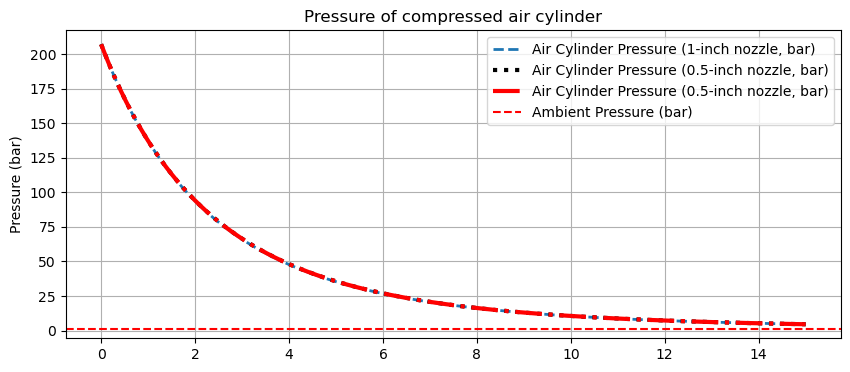

In [74]:
# Plot results
plt.figure(figsize=(10,4))
plt.plot(time, P1_1 / 1e5, label="Air Cylinder Pressure (1-inch nozzle, bar)", lw=2, linestyle='--')
plt.plot(time, P1_2 / 1e5, label="Air Cylinder Pressure (0.5-inch nozzle, bar)", linestyle='dotted', lw=3, color = 'k')
plt.plot(time, P1_2 / 1e5, label="Air Cylinder Pressure (0.5-inch nozzle, bar)", linestyle='dashdot', lw=3, color='r')
plt.axhline(P_ambient / 1e5, color='r', linestyle='--', label="Ambient Pressure (bar)")
plt.ylabel("Pressure (bar)")
plt.title('Pressure of compressed air cylinder')
plt.legend()
plt.grid()
plt.show()

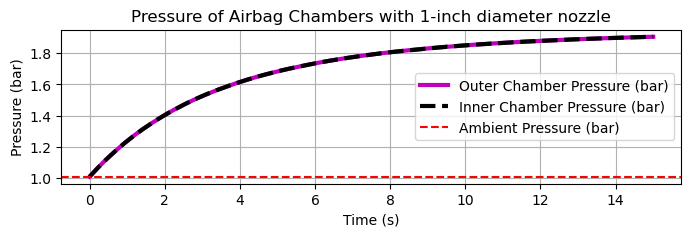

In [115]:
# Intermediate and final chamber pressures
plt.figure(figsize=(8,2))
plt.plot(time, P2_1 / 1e5, label="Outer Chamber Pressure (bar)", lw=3, color='m')
plt.plot(time, P3_1 / 1e5, label="Inner Chamber Pressure (bar)", lw=3, linestyle='--', color='k')
plt.axhline(P_ambient / 1e5, color='r', linestyle='--', label="Ambient Pressure (bar)")
plt.ylabel("Pressure (bar)")
plt.xlabel("Time (s)")
plt.title('Pressure of Airbag Chambers with 1-inch diameter nozzle')
plt.legend()
plt.grid()
plt.savefig('1 inch nozzle.jpg')

plt.show()

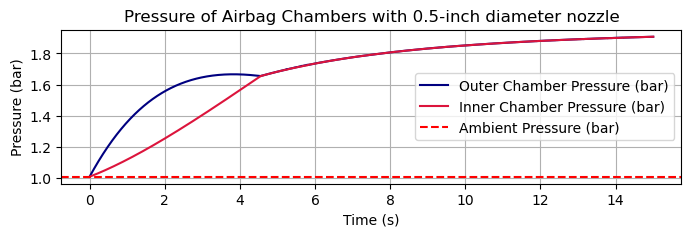

In [116]:
plt.figure(figsize=(8,2))
plt.plot(time, P2_2 / 1e5, label="Outer Chamber Pressure (bar)", color='navy')
plt.plot(time, P3_2 / 1e5, label="Inner Chamber Pressure (bar)", color='crimson')
plt.axhline(P_ambient / 1e5, color='r', linestyle='--', label="Ambient Pressure (bar)")
plt.ylabel("Pressure (bar)")
plt.xlabel("Time (s)")
plt.title('Pressure of Airbag Chambers with 0.5-inch diameter nozzle')
plt.legend()
plt.grid()
plt.savefig('0.5 inch nozzle.jpg')
plt.show()

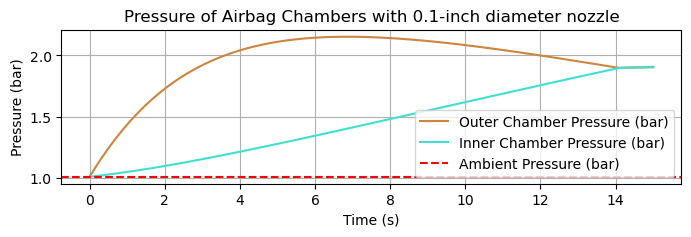

In [117]:
plt.figure(figsize=(8,2))
plt.plot(time, P2_3 / 1e5, label="Outer Chamber Pressure (bar)", color='peru')
plt.plot(time, P3_3 / 1e5, label="Inner Chamber Pressure (bar)", color='turquoise')
plt.axhline(P_ambient / 1e5, color='r', linestyle='--', label="Ambient Pressure (bar)")
plt.ylabel("Pressure (bar)")
plt.xlabel("Time (s)")
plt.title('Pressure of Airbag Chambers with 0.1-inch diameter nozzle')
plt.legend()
plt.grid()
plt.savefig('0.1 inch nozzle.jpg')
plt.show()

With decreasing nozzle size, we see an increase in initial inflation time, but the pressure differential between chambers will increase the stress on the material of the outer layer, and increases time to hit equilibrium pressue. For our specific use case, we determined a 0.3" nozzle to give us the optimal theoretical performance, but will be testing diameters larger and smaller than this to validate these findings. 